## 1. Preprocess

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

In [2]:
X_train, X_test, Y_train, Y_test = np.expand_dims(x_train, axis=3), np.expand_dims(x_test, axis=3), np.expand_dims(y_train, axis=1), np.expand_dims(y_test, axis=1)

# X_train, Y_train, X_test, Y_test = X_train[:1000], Y_train[:1000], X_test[:100], Y_test[:100]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [3]:
X_train, X_test = X_train/255, X_test/255

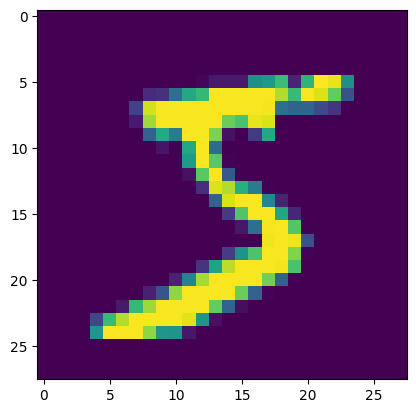

In [4]:
plt.imshow(X_train[0])

In [5]:
new_Y_train = np.zeros((60000, 10))
# print(len(Y_train))
for i in range(len(Y_train)):
    # print(i, Y_train[i][0])
    new_Y_train[i, Y_train[i][0]] = 1

new_Y_test = np.zeros((10000, 10))
# print(len(Y_train))
for i in range(len(Y_test)):
    # print(i, Y_train[i][0])
    new_Y_test[i, Y_test[i][0]] = 1


new_Y_train.shape, new_Y_test.shape

((60000, 10), (10000, 10))

In [6]:
Y_train, Y_test = new_Y_train, new_Y_test

In [8]:
import os

while os.getcwd().split("\\")[-1] != "ComputerVisionSoc":
    os.chdir("..")

os.getcwd()

'E:\\Editor\\ComputerVisionSoc'

In [15]:
samples = []
for img in os.listdir("datasets/sample_image"):
    image = cv2.imread("datasets/sample_image/"+img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) 

    samples.append(image)

len(samples)

20

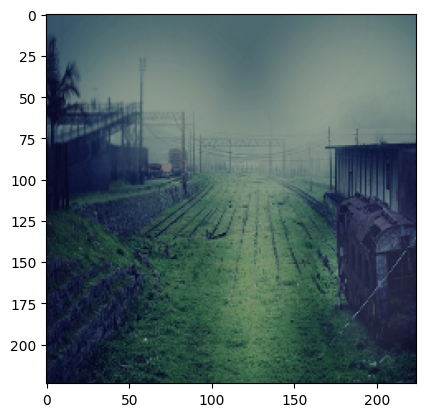

In [23]:
plt.imshow(samples[np.random.randint(0, 20)])
plt.show()

## 2. Convolutional filters

In [68]:
edge_detection = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
blurring = np.array([[1, 2, 1],
                      [2, 4, 2],
                      [1, 2, 1]]) / 16

sharpening = np.array([[ 0, -1,  0],
                       [-1,  5, -1],
                       [ 0, -1,  0]])

embossing = np.array([[-2, -1,  0],
                   [-1,  1,  1],
                   [ 0,  1,  2]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


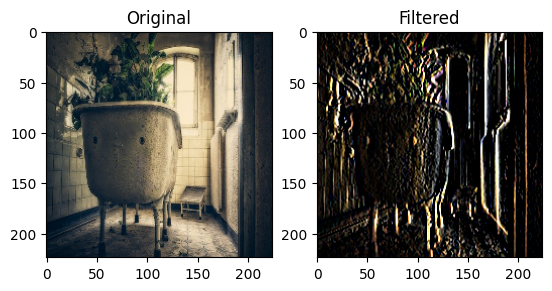

In [176]:
rand_img = samples[np.random.randint(0, 20)]
rand_img = rand_img/255
# rand_img = X_train[np.random.randint(1, len(X_train))]
kernel = edge_detection


# plt.imshow(rand_img)
filtered = cv2.filter2D(rand_img, -1, kernel)
plt.subplot(1,2,1), plt.imshow(rand_img, cmap='gray'), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(filtered, cmap='gray'), plt.title("Filtered")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


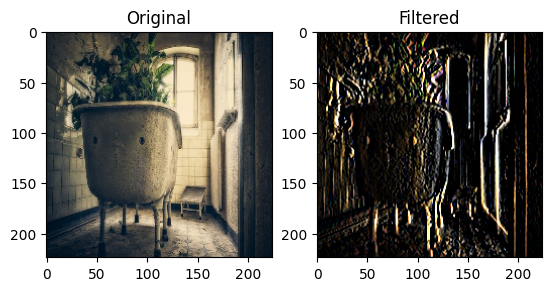

In [177]:
def apply_filter(image, kernel, padding="same"):
    # Get image and kernel dimensions
    img_height, img_width, num_channels = image.shape
    kernel_height, kernel_width = kernel.shape

    # Determine padding size
    if padding == "same":
        pad_height = (kernel_height - 1) // 2
        pad_width = (kernel_width - 1) // 2
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode="constant", constant_values=0)
    else:
        padded_image = image

    # Output image (same shape as input)
    output_img = np.zeros_like(image)

    # Convolve the image with the kernel
    for i in range(img_height):
        for j in range(img_width):
            # Define the region of interest (3x3 in this case)
            region = padded_image[i:i + kernel_height, j:j + kernel_width, :]
            
            # Apply the kernel to the region (element-wise multiplication and sum)
            output_img[i, j] = np.sum(region * kernel[:, :, None], axis=(0, 1))  # Sum over kernel height and width

    return output_img

filtered = (apply_filter(rand_img, kernel, "same"))
plt.subplot(1,2,1), plt.imshow(rand_img, cmap='gray'), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(filtered, cmap='gray'), plt.title("Filtered")
plt.show()

## 3. Pooling layers

In [200]:
def max_pooling(img, pool_size=2, stride=2):
    h, w = img.shape[:2]  # Get the height and width of the image
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    pooled_img = np.zeros((out_h, out_w, img.shape[-1]))  # Output image after pooling

    for i in range(0, out_h):
        for j in range(0, out_w):
            region = img[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size, :]
            # print(pooled_img[i, j].shape, np.max(region, axis=(0, 1)).shape)
            pooled_img[i, j] = np.max(region, axis=(0, 1))  # Apply MaxPooling
    
    return pooled_img

def avg_pooling(img, pool_size=2, stride=2):
    h, w = img.shape[:2]
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    pooled_img = np.zeros((out_h, out_w, img.shape[-1]))

    for i in range(0, out_h):
        for j in range(0, out_w):
            region = img[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size, :]
            # print(pooled_img[i, j].shape, np.mean(region, axis=(0, 1)).shape)
            pooled_img[i, j] = np.mean(region, axis=(0, 1))  # Apply AveragePooling
    
    return pooled_img


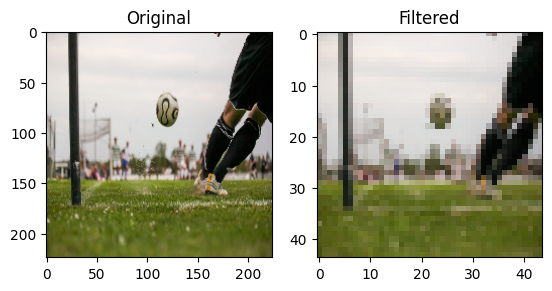

In [204]:
rand_img = samples[np.random.randint(0, 20)]
rand_img = rand_img/255
# rand_img = X_train[np.random.randint(1, len(X_train))]

pooled = avg_pooling(rand_img, 5, 5)

# plt.imshow(rand_img)
plt.subplot(1,2,1), plt.imshow(rand_img, cmap='gray'), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(pooled, cmap='gray'), plt.title("Pooled")
plt.show()